In [7]:
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import random
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from sklearn.model_selection import train_test_split


In [2]:


# Label mapping: (Main Folder, Compartment Folder) → Label
compartment_labels = {
    ("VCB", "CB Close Door"): 0,
    ("VCB", "CB Open door"): 1,
    ("VCB", "3 Core Cable"): 2,
    ("VCB", "1 core cable"): 3,
    ("VCB", "Cable"): 5,
    ("VCB", "Busbar top"): 6,
    ("VCB", "Busbar side"): 7,
    ("VCB", "PT"): 10,
    
    ("RMU", "Cable Entry"): 4,
    ("RMU", "Fuse"): 8,
    ("RMU", "Cable"): 5,
    ("RMU", "PT"): 10
}

image_paths = []
labels = []

base_path = './data/resized_output'
unmatched_folders = set()

# Loop through all .png files and match the folder path pair
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('_resized.png'):
            full_path = os.path.join(root, file)
            folder_name = os.path.basename(root)  # e.g. "Cable"
            parent_folder = os.path.basename(os.path.dirname(root))  # e.g. "VCB" or "RMU"

            key = (parent_folder, folder_name)

            if key in compartment_labels:
                label = compartment_labels[key]
                image_paths.append(full_path)
                labels.append(label)
            else:
                unmatched_folders.add(key)

print(f"✅ Total labeled images: {len(image_paths)}")
print("📊 Label Distribution:", Counter(labels))

if unmatched_folders:
    print("\n🚫 Unmatched folder pairs (check for typos or missing labels):")
    for f in sorted(unmatched_folders):
        print("-", f)

✅ Total labeled images: 357
📊 Label Distribution: Counter({5: 51, 3: 40, 6: 40, 1: 40, 7: 40, 0: 40, 4: 40, 8: 40, 10: 26})


In [3]:


# Convert labels to numpy array (if not already)
label_array = np.array(labels)

# Get unique class IDs
classes = np.unique(label_array)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=label_array)

# Store as dictionary for model use
class_weight_dict = dict(zip(classes, class_weights))

# Output the weights
print("📊 Class Weights:")
for cls, weight in class_weight_dict.items():
    print(f"Class {cls}: Weight {weight:.2f}")

📊 Class Weights:
Class 0: Weight 0.99
Class 1: Weight 0.99
Class 3: Weight 0.99
Class 4: Weight 0.99
Class 5: Weight 0.78
Class 6: Weight 0.99
Class 7: Weight 0.99
Class 8: Weight 0.99
Class 10: Weight 1.53


In [4]:


# --- 1. Load Your Images (resized: 640x480) ---
img_width = 224  # MobileNet expects smaller size
img_height = 224
num_classes = max(labels) + 1

images = []
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, (img_width, img_height))  # Resize to MobileNetV2 input
    img = img / 255.0
    images.append(img)

X = np.array(images)
y = to_categorical(labels, num_classes=num_classes)

# --- 2. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Class Weights (ensure coverage) ---
label_array = np.argmax(y_train, axis=1)
classes = np.unique(label_array)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=label_array)
# Safer class weight mapping using zip
raw_weight_dict = dict(zip(classes, class_weights))
class_weight_dict = {i: raw_weight_dict.get(i, 1.0) for i in range(num_classes)}


# --- 4. Build MobileNetV2 Transfer Model ---
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the pretrained layers

inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# --- 5. Compile ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 6. Callbacks ---
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# --- 7. Train ---
history = model.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    callbacks=[early_stop])

2025-04-30 19:26:46.909258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-30 19:26:46.909440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asma/thermal-cnn/lib/python3.7/site-packages/cv2/../../lib64:
2025-04-30 19:26:46.909507: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asma/thermal-cnn/lib/python3.7/site-packages/cv2/../../lib64:
2025-04-30 19:26:46.909560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could no

Epoch 1/25
9/9 [==============================] - 6s 432ms/step - loss: 2.1526 - accuracy: 0.2877 - val_loss: 1.0766 - val_accuracy: 0.8194
Epoch 2/25
9/9 [==============================] - 3s 342ms/step - loss: 1.1835 - accuracy: 0.6175 - val_loss: 0.7072 - val_accuracy: 0.8611
Epoch 3/25
9/9 [==============================] - 3s 355ms/step - loss: 0.7688 - accuracy: 0.7614 - val_loss: 0.5492 - val_accuracy: 0.8889
Epoch 4/25
9/9 [==============================] - 3s 358ms/step - loss: 0.5601 - accuracy: 0.8211 - val_loss: 0.4870 - val_accuracy: 0.9028
Epoch 5/25
9/9 [==============================] - 3s 357ms/step - loss: 0.4179 - accuracy: 0.9193 - val_loss: 0.4031 - val_accuracy: 0.8889
Epoch 6/25
9/9 [==============================] - 3s 341ms/step - loss: 0.3376 - accuracy: 0.9193 - val_loss: 0.3948 - val_accuracy: 0.9028
Epoch 7/25
9/9 [==============================] - 3s 351ms/step - loss: 0.2788 - accuracy: 0.9193 - val_loss: 0.3542 - val_accuracy: 0.9028
Epoch 8/25
9/9 [====

3/3 [==============================] - 1s 167ms/step - loss: 0.4870 - accuracy: 0.9028
✅ MobileNetV2 Test Accuracy: 90.28%


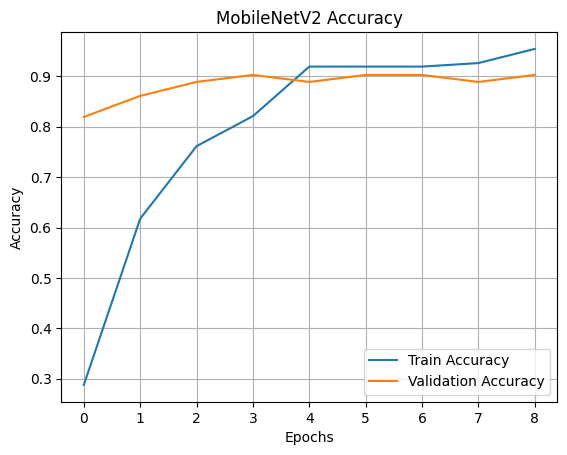

In [5]:
# --- Evaluate ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ MobileNetV2 Test Accuracy: {accuracy * 100:.2f}%")

# --- Save Model ---
model.save("thermal_mobilenetv2_classifier.h5")

# --- Plot Accuracy ---
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("MobileNetV2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

3/3 [==============================] - 1s 156ms/step


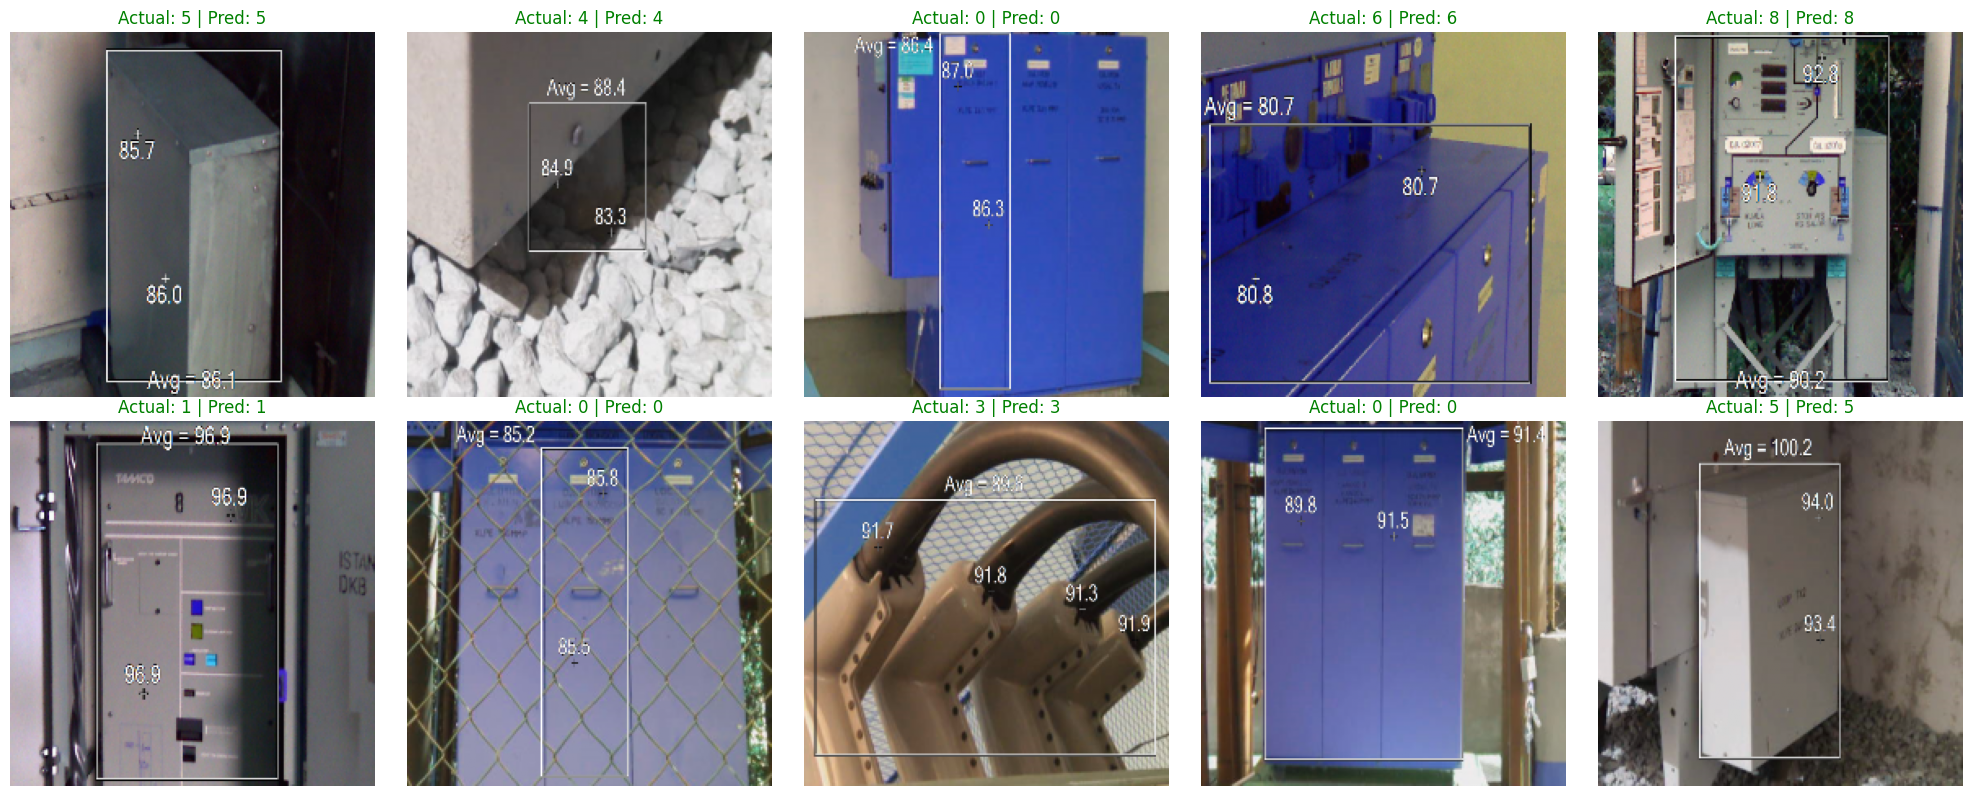

In [6]:

# --- 1. Make predictions ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# --- 2. Pick 10 random indices ---
sample_indices = random.sample(range(len(X_test)), 10)

# --- 3. Plot images with predictions ---
plt.figure(figsize=(20, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    plt.title(f"Actual: {y_true[idx]} | Pred: {y_pred[idx]}", fontsize=12, color='green' if y_true[idx] == y_pred[idx] else 'red')
plt.tight_layout()
plt.show()

In [17]:
import os
import cv2
import numpy as np
import pandas as pd

base_dir = './data/resized_output'
target_size = (224, 224)  # SegNet input

created = 0

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('_resized.png') and 'IR_' in file:
            base_name = file.replace('_resized.png', '')
            img_path = os.path.join(root, file)
            csv_path = os.path.join(root, base_name + '_resized.csv')
            mask_path = os.path.join(root, base_name + '_resized_mask.png')

            if os.path.exists(csv_path):
                try:
                    temp_data = pd.read_csv(csv_path, header=None).values.astype(np.float32)
                    temp_data = np.nan_to_num(temp_data)

                    # Resize to match target size
                    resized_temp = cv2.resize(temp_data, target_size, interpolation=cv2.INTER_NEAREST)

                    # Create mask using 90th percentile as hotspot threshold
                    threshold = np.percentile(resized_temp, 90)
                    mask = (resized_temp >= threshold).astype(np.uint8)

                    # Optional: multiply by 255 for visibility (if needed)
                    mask_img = (mask * 255).astype(np.uint8)

                    cv2.imwrite(mask_path, mask_img)
                    created += 1
                    print(f"✅ Mask created: {mask_path}")
                except Exception as e:
                    print(f"⚠️ Error reading {csv_path}: {e}")
            else:
                print(f"❌ CSV not found for {img_path}")

print(f"\n🎉 Done! Created {created} masks.")

✅ Mask created: ./data/resized_output/VCB/Cable/IR_06963_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/Cable/IR_06965_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/Cable/IR_08504_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/Cable/IR_08458_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/Cable/IR_08472_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/Cable/IR_06961_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/Cable/IR_07374_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/Cable/IR_08403_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/1 core cable/IR_06737_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/1 core cable/IR_06794_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/1 core cable/IR_06745_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/1 core cable/IR_06751_resized_mask.png
✅ Mask created: ./data/resized_output/VCB/1 core cable/IR_06720_resized_mask.png
✅ M

In [18]:
def build_segnet(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    # Decoder
    x = UpSampling2D(2)(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    x = UpSampling2D(2)(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)

    x = UpSampling2D(2)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)

    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [20]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

image_dir = './data/resized_output'
images = []
masks = []

img_size = (224, 224)
num_classes = 2  # Change to match actual number of segmentation classes

# Walk through VCB and RMU directories recursively
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith('_resized.png') and 'IR_' in file:
            img_path = os.path.join(root, file)
            mask_name = file.replace('_resized.png', '_resized_mask.png')
            mask_path = os.path.join(root, mask_name)

            print(f"🖼️ Checking: {file} | Looking for mask: {mask_name}")
            
            if os.path.exists(mask_path):
                # Load and resize image
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = img / 255.0  # Normalize
                
                # Load and resize mask
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, img_size)

                # Fix mask values: convert 255 → 1
                mask[mask == 255] = 1


                # Convert to one-hot (if needed)
                mask_cat = to_categorical(mask, num_classes=num_classes)

                images.append(img)
                masks.append(mask_cat)
                print(f"✅ Loaded pair: {file}")
            else:
                print(f"❌ Mask not found for: {file}")

# Convert to NumPy arrays
X = np.array(images)
y = np.array(masks)

print(f"\n📦 Loaded total: {len(X)} image-mask pairs")

🖼️ Checking: IR_06963_resized.png | Looking for mask: IR_06963_resized_mask.png
✅ Loaded pair: IR_06963_resized.png
🖼️ Checking: IR_06965_resized.png | Looking for mask: IR_06965_resized_mask.png
✅ Loaded pair: IR_06965_resized.png
🖼️ Checking: IR_08504_resized.png | Looking for mask: IR_08504_resized_mask.png
✅ Loaded pair: IR_08504_resized.png
🖼️ Checking: IR_08458_resized.png | Looking for mask: IR_08458_resized_mask.png
✅ Loaded pair: IR_08458_resized.png
🖼️ Checking: IR_08472_resized.png | Looking for mask: IR_08472_resized_mask.png
✅ Loaded pair: IR_08472_resized.png
🖼️ Checking: IR_06961_resized.png | Looking for mask: IR_06961_resized_mask.png
✅ Loaded pair: IR_06961_resized.png
🖼️ Checking: IR_07374_resized.png | Looking for mask: IR_07374_resized_mask.png
✅ Loaded pair: IR_07374_resized.png
🖼️ Checking: IR_08403_resized.png | Looking for mask: IR_08403_resized_mask.png
✅ Loaded pair: IR_08403_resized.png
🖼️ Checking: IR_06737_resized.png | Looking for mask: IR_06737_resized_m

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = build_segnet(input_shape=(224, 224, 3), num_classes=2)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X, y,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=8,
                    callbacks=[early_stop])

Epoch 1/10
20/20 [==============================] - 53s 3s/step - loss: 0.4438 - accuracy: 0.8521 - val_loss: 0.3623 - val_accuracy: 0.8915
Epoch 2/10
20/20 [==============================] - 56s 3s/step - loss: 0.3553 - accuracy: 0.8875 - val_loss: 0.3511 - val_accuracy: 0.8915
Epoch 3/10
20/20 [==============================] - 56s 3s/step - loss: 0.3418 - accuracy: 0.8875 - val_loss: 0.3428 - val_accuracy: 0.8915
Epoch 4/10
20/20 [==============================] - 56s 3s/step - loss: 0.3352 - accuracy: 0.8875 - val_loss: 0.3214 - val_accuracy: 0.8915
Epoch 5/10
20/20 [==============================] - 56s 3s/step - loss: 0.3343 - accuracy: 0.8875 - val_loss: 0.3246 - val_accuracy: 0.8929
Epoch 6/10
20/20 [==============================] - 56s 3s/step - loss: 0.3334 - accuracy: 0.8877 - val_loss: 0.3456 - val_accuracy: 0.8932
Epoch 7/10
20/20 [==============================] - 56s 3s/step - loss: 0.3303 - accuracy: 0.8883 - val_loss: 0.3245 - val_accuracy: 0.8936
Epoch 8/10
20/20 [==

1/1 [==============================] - 0s 78ms/step


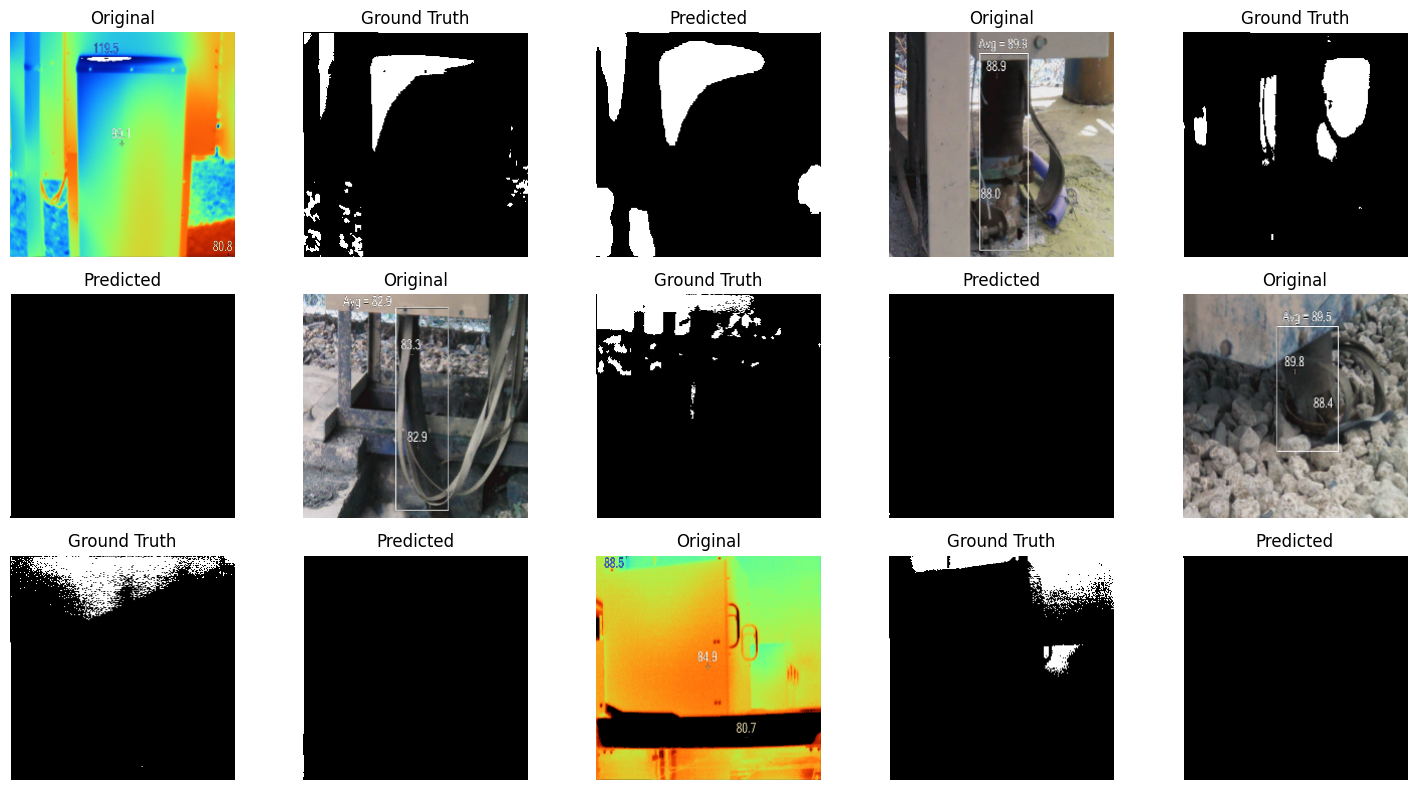

In [22]:
import matplotlib.pyplot as plt
import random

sample_indices = random.sample(range(len(X)), 5)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    pred = model.predict(np.expand_dims(X[idx], axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    true_mask = np.argmax(y[idx], axis=-1)

    plt.subplot(3, 5, i*3 + 1)
    plt.imshow(X[idx])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(3, 5, i*3 + 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3, 5, i*3 + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
import pandas as pd

def compute_delta_T(temp_csv_path, pred_mask):
    # Load temperature matrix from CSV
    temp_map = pd.read_csv(temp_csv_path, header=None).values
    
    # Ensure shapes match
    if temp_map.shape != pred_mask.shape:
        temp_map = cv2.resize(temp_map, (pred_mask.shape[1], pred_mask.shape[0]))
    
    # Boolean masks
    roi_pixels = temp_map[pred_mask == 1]
    background_pixels = temp_map[pred_mask == 0]

    # Safety check
    if len(roi_pixels) == 0:
        print("⚠️ No predicted hotspot pixels found.")
        return None, None, None

    roi_mean = np.mean(roi_pixels)
    background_mean = np.mean(background_pixels)
    delta_T = roi_mean - background_mean

    return roi_mean, background_mean, delta_T

In [29]:
print("Mask Shape:", predicted_mask_binary.shape)
print("ROI Pixels:", np.sum(predicted_mask_binary == 1))
print("BG Pixels:", np.sum(predicted_mask_binary == 0))

Mask Shape: (224, 224)
ROI Pixels: 443
BG Pixels: 49733


In [30]:
import pandas as pd

csv_path = './data/resized_output/VCB/Cable/IR_08472_resized.csv'
df = pd.read_csv(csv_path, header=None)
print("CSV Shape:", df.shape)

CSV Shape: (480, 640)


In [31]:
from skimage.transform import resize

# Resize predicted binary mask to match the CSV shape
predicted_mask_resized = resize(predicted_mask_binary, (480, 640), order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

# Then compute ΔT using resized mask
roi_mean, bg_mean, delta_T = compute_delta_T(csv_path, predicted_mask_resized)

In [36]:
print("Mask stats:", np.unique(predicted_mask_resized, return_counts=True))
print("Mask shape:", predicted_mask_resized.shape)

Mask stats: (array([0, 1], dtype=uint8), array([304510,   2690]))
Mask shape: (480, 640)


In [39]:
import numpy as np
import pandas as pd

# ✅ Path to your CSV file
csv_path = "./data/resized_output/VCB/Cable/IR_08472_resized.csv"

# ✅ Load and check
df = pd.read_csv(csv_path, header=None)
temp_array = df.values

# ✅ Check CSV content
print("CSV shape:", temp_array.shape)
print("CSV dtype:", temp_array.dtype)
print("NaNs in CSV:", np.isnan(temp_array).sum())
print("Min temp:", np.min(temp_array))
print("Max temp:", np.max(temp_array))

CSV shape: (480, 640)
CSV dtype: float64
NaNs in CSV: 484
Min temp: nan
Max temp: nan


In [40]:
# Replace NaNs with 0 or a more meaningful value like the median of valid pixels
temp_array_cleaned = np.nan_to_num(temp_array, nan=np.nanmedian(temp_array))

# Now check stats again
print("Cleaned Min temp:", np.min(temp_array_cleaned))
print("Cleaned Max temp:", np.max(temp_array_cleaned))
print("Still any NaNs?", np.isnan(temp_array_cleaned).sum())

Cleaned Min temp: 1.0
Cleaned Max temp: 320.0
Still any NaNs? 0


In [48]:
import cv2
import numpy as np

# Load predicted mask from file (grayscale)
pred_mask_path = "./data/resized_output/VCB/Cable/IR_08472_resized_mask.png"
predicted_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)

# Optional: Resize to match CSV dimensions if needed (usually 640x480)
predicted_mask = cv2.resize(predicted_mask, (640, 480), interpolation=cv2.INTER_NEAREST)

# Convert to binary (assuming mask values like 0, 1, 2, 3... etc)
predicted_mask_binary = (predicted_mask > 0).astype(np.uint8)  # 1 for hotspot, 0 for background

In [49]:
mask_pred = predicted_mask_binary

In [50]:
roi_values = temp_array_cleaned[mask_pred == 1]
bg_values = temp_array_cleaned[mask_pred == 0]
roi_mean = np.mean(roi_values)
bg_mean = np.mean(bg_values)
delta_T = roi_mean - bg_mean

print(f"🌡️ ROI Mean = {roi_mean:.2f}°C | BG Mean = {bg_mean:.2f}°C")
print(f"🔥 ΔT = {delta_T:.2f}°C")

🌡️ ROI Mean = 90.27°C | BG Mean = 85.80°C
🔥 ΔT = 4.47°C


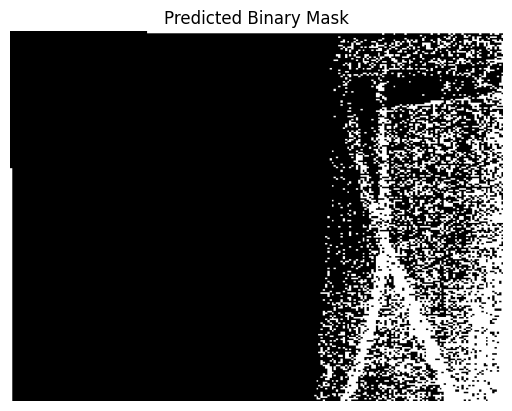

In [51]:
plt.imshow(predicted_mask_binary, cmap='gray')
plt.title("Predicted Binary Mask")
plt.axis('off')
plt.show()

In [52]:
import numpy as np
import pandas as pd
import cv2

def compute_delta_T(csv_path, mask_path, target_size=(640, 480)):
    # Load CSV thermal data
    temp_array = pd.read_csv(csv_path, header=None).values.astype(np.float32)
    temp_array = np.nan_to_num(temp_array)  # Clean NaNs

    # Resize thermal array to target size
    temp_array = cv2.resize(temp_array, target_size, interpolation=cv2.INTER_NEAREST)

    # Load and resize mask
    predicted_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    predicted_mask = cv2.resize(predicted_mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Binarize mask
    binary_mask = (predicted_mask > 0).astype(np.uint8)

    # Compute ROI and BG mean
    roi_values = temp_array[binary_mask == 1]
    bg_values = temp_array[binary_mask == 0]
    roi_mean = np.mean(roi_values)
    bg_mean = np.mean(bg_values)
    delta_T = roi_mean - bg_mean

    return roi_mean, bg_mean, delta_T

In [53]:
csv_path = "./data/resized_output/VCB/Cable/IR_08472_resized.csv"
mask_path = "./data/resized_output/VCB/Cable/IR_08472_resized_mask.png"

roi, bg, delta = compute_delta_T(csv_path, mask_path)
print(f"🌡️ ROI Mean = {roi:.2f}°C | BG Mean = {bg:.2f}°C\n🔥 ΔT = {delta:.2f}°C")

🌡️ ROI Mean = 89.62°C | BG Mean = 85.76°C
🔥 ΔT = 3.86°C


In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_roi_and_temp(csv_path, mask_path, original_img_path, output_path=None):
    # Load and resize thermal data
    temp_array = pd.read_csv(csv_path, header=None).values.astype(np.float32)
    temp_array = np.nan_to_num(temp_array)
    temp_array = cv2.resize(temp_array, (640, 480), interpolation=cv2.INTER_NEAREST)

    # Load original image (for visualization)
    thermal_img = cv2.imread(original_img_path)
    thermal_img = cv2.resize(thermal_img, (640, 480))

    # Load predicted mask
    predicted_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    predicted_mask = cv2.resize(predicted_mask, (640, 480))
    binary_mask = (predicted_mask > 0).astype(np.uint8)

    # Calculate ROI and background temperatures
    roi_vals = temp_array[binary_mask == 1]
    bg_vals = temp_array[binary_mask == 0]
    roi_mean = np.mean(roi_vals)
    bg_mean = np.mean(bg_vals)
    delta_T = roi_mean - bg_mean

    # Create mask overlay
    overlay = thermal_img.copy()
    overlay[binary_mask == 1] = [0, 0, 255]  # Red for hotspot
    blended = cv2.addWeighted(thermal_img, 0.7, overlay, 0.3, 0)

    # Draw temperature info
    cv2.putText(blended, f"ROI: {roi_mean:.2f}°C", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
    cv2.putText(blended, f"BG: {bg_mean:.2f}°C", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
    cv2.putText(blended, f"Delta T: {delta_T:.2f}°C", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

    # Save if needed
    if output_path:
        cv2.imwrite(output_path, blended)

    # Show the result
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Hotspot Detection with ΔT")
    plt.show()

    return roi_mean, bg_mean, delta_T

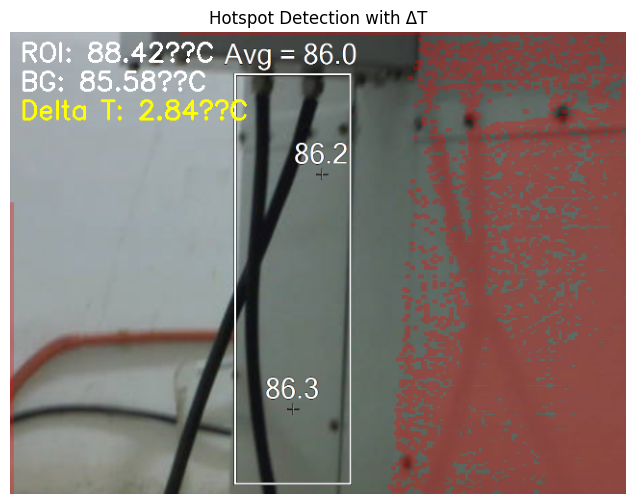

(88.42229, 85.579155, 2.843132)

In [55]:
overlay_roi_and_temp(
    csv_path="./data/resized_output/VCB/Cable/IR_08472_resized.csv",
    mask_path="./data/resized_output/VCB/Cable/IR_08472_resized_mask.png",
    original_img_path="./data/resized_output/VCB/Cable/IR_08472_resized.png",
    output_path="./annotated_output/IR_08472_overlay.png"
)

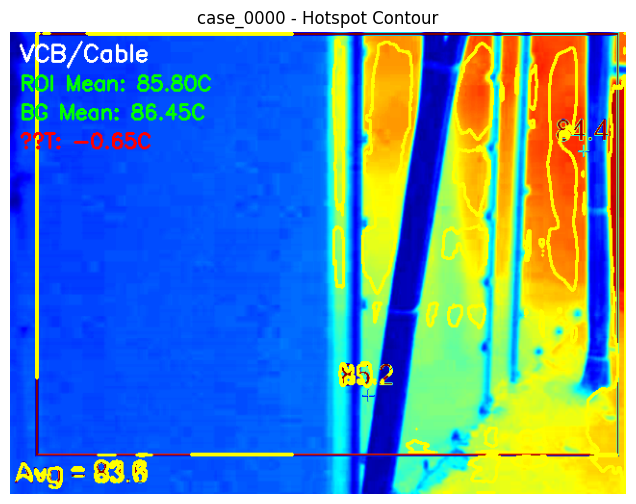

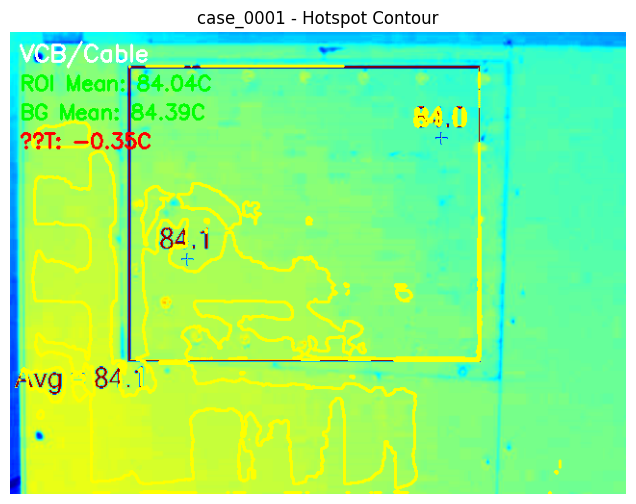

In [58]:
import os
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

# Define mapping
csv_map = {
    "case_0000": "./data/resized_output/VCB/Cable/IR_08472_resized.csv",
    "case_0001": "./data/resized_output/VCB/Cable/IR_06961_resized.csv",
}
compartment_map = {
    "case_0000": ("VCB", "Cable"),
    "case_0001": ("VCB", "Cable"),
}

# Paths
pred_dir = "./nnUNet_predictions"
image_dir = "./nnUNet_raw_data/Dataset001_ThermalSeg/imagesTr"

for case_id, csv_path in csv_map.items():
    pred_path = os.path.join(pred_dir, f"{case_id}.nii.gz")
    img_path = os.path.join(image_dir, f"{case_id}_0000.nii.gz")

    if not os.path.exists(pred_path) or not os.path.exists(img_path) or not os.path.exists(csv_path):
        print(f"❌ Missing file(s) for {case_id}")
        continue

    # Load data
    mask = nib.load(pred_path).get_fdata()[0].astype(np.uint8)
    thermal = nib.load(img_path).get_fdata()[0]

    # Load and align temperature data
    csv_temp = pd.read_csv(csv_path, header=None).values.astype(np.float32)
    csv_temp = np.nan_to_num(csv_temp)
    csv_temp = cv2.resize(csv_temp, (thermal.shape[1], thermal.shape[0]))

    # Normalize for display
    thermal_vis = cv2.normalize(thermal, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    thermal_color = cv2.applyColorMap(thermal_vis, cv2.COLORMAP_JET)

    # Find contours on ROI
    roi_mask = (mask > 0).astype(np.uint8)
    contours, _ = cv2.findContours(roi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(thermal_color, contours, -1, (0, 255, 255), 2)  # Yellow outline

    # Compute ΔT
    roi_vals = csv_temp[roi_mask == 1]
    bg_vals = csv_temp[roi_mask == 0]
    roi_mean = np.mean(roi_vals)
    bg_mean = np.mean(bg_vals)
    delta_T = roi_mean - bg_mean

    # Annotate info
    parent, comp = compartment_map.get(case_id, ("Unknown", "Unknown"))
    cv2.putText(thermal_color, f"{parent}/{comp}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
    cv2.putText(thermal_color, f"ROI Mean: {roi_mean:.2f}C", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    cv2.putText(thermal_color, f"BG Mean: {bg_mean:.2f}C", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    cv2.putText(thermal_color, f"ΔT: {delta_T:.2f}C", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    # Show result
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(thermal_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{case_id} - Hotspot Contour")
    plt.show()